##### Imports

In [1]:
import gzip
import os
import shutil
import subprocess
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap

##### Illumina trimming

In [2]:
f1 = Path("fus11/reads/raw/illumina_1.fq.gz")
f2 = Path("fus11/reads/raw/illumina_2.fq.gz")
output = Path("fus11/reads/trimmed/")


if not (output/"illumina_1.fq.gz").exists():
    os.makedirs(output, exist_ok=True)
    cmd = (
        f"trim_galore -length 40 -o {output} --cores 4 --paired "
        f"--no_report_file {f1} {f2}")
    subprocess.run(cmd, shell=True)
    shutil.move(output/"illumina_val_1.fq.gz", output/"illumina_1.fq.gz")
    shutil.move(output/"illumina_val_2.fq.gz", output/"illumina_2.fq.gz")

##### Reference alignment of reads

In [8]:
f1 = Path("fus11/reads/trimmed/illumina_1.fq.gz")
f2 = Path("fus11/reads/trimmed/illumina_2.fq.gz")
nr = Path("fus11/reads/trimmed/nanopore.fq.gz")
reference = Path("genomes/fna/GCF_013085055.1.fna").resolve()
output = Path("alignment/")


ref = output/"ref/ref.fa"
os.makedirs(output/"ref", exist_ok=True)
os.makedirs(output/"reads", exist_ok=True)

# Create symlink
if not ref.exists():
    cmd = f"cd {output/'ref'} && ln -s {reference} ref.fa"
    subprocess.run(cmd, shell=True)

# Index reference genome
if not os.path.exists(f"{ref}.sa"):
    cmd = f"bwa index {ref}"
    subprocess.run(cmd, shell=True)

# Align reads to reference
if not (output/"reads/nanopore.sam").exists():
    cmd = f"bwa mem -t 10 {ref} {nr} > {output/'reads/nanopore.sam'}"
    subprocess.run(cmd, shell=True)
if not (output/"reads/illumina.sam").exists():
    cmd = f"bwa mem -t 10 {ref} {f1} {f2} > {output/'reads/illumina.sam'}"
    subprocess.run(cmd, shell=True)

for source in ["nanopore", "illumina"]:

    # Create BAM file
    if not (output/f"reads/{source}.bam").exists():
        inp = output/f"reads/{source}.sam"
        out = output/f"reads/{source}.bam"
        cmd = f"samtools view -@ 8 -bS {inp} > {out}"
        subprocess.run(cmd, shell=True)
    
    # Sort BAM file
    if not (output/f"reads/{source}.sorted.bam").exists():
        inp = output/f"reads/{source}.bam"
        out = output/f"reads/{source}.sorted.bam"
        cmd = f"samtools sort -@ 8 -o {out} {inp}"
        subprocess.run(cmd, shell=True)
    
    # Caculate per-base depth
    if not (output/f"reads/{source}-depth.tsv").exists():
        inp = output/f"reads/{source}.sorted.bam"
        out = output/f"reads/{source}-depth.tsv"
        cmd = f"samtools depth -@ 8 -aa {inp} > {out}"
        subprocess.run(cmd, shell=True)

    # Get consensus fasta file
    if not (output/f"reads/{source}-consensus.fa").exists():
        inp = output/f"reads/{source}.sorted.bam"
        out = output/f"reads/{source}-consensus.fa"
        cmd = f"samtools consensus -a -@ 8 -f FASTA -o {out} {inp}"
        subprocess.run(cmd, shell=True)

    # Calculate coverage
    if not (output/f"reads/{source}-coverage.tsv").exists():
        inp = output/f"reads/{source}.sorted.bam"
        out = output/f"reads/{source}-coverage.tsv"
        cmd = f"samtools coverage {inp} > {out}"
        subprocess.run(cmd, shell=True)

samtools: /home/anton/micromamba/envs/pancluster/bin/../lib/libtinfow.so.6: no version information available (required by samtools)
samtools: /home/anton/micromamba/envs/pancluster/bin/../lib/libncursesw.so.6: no version information available (required by samtools)
samtools: /home/anton/micromamba/envs/pancluster/bin/../lib/libncursesw.so.6: no version information available (required by samtools)
samtools: /home/anton/micromamba/envs/pancluster/bin/../lib/libtinfow.so.6: no version information available (required by samtools)
samtools: /home/anton/micromamba/envs/pancluster/bin/../lib/libncursesw.so.6: no version information available (required by samtools)
samtools: /home/anton/micromamba/envs/pancluster/bin/../lib/libncursesw.so.6: no version information available (required by samtools)


##### Reference alignment of contigs

In [ ]:
illumina = Path("fus11/assembly/illumina.fa")
hybrid = Path("fus11/assembly/hybrid.fa")
reference = Path("genomes/fna/GCF_013085055.1.fna").resolve()
output = Path("alignment/")


ref = output/"ref/ref.fa"
os.makedirs(output/"ref", exist_ok=True)
os.makedirs(output/"contigs", exist_ok=True)

# Create symlink
if not ref.exists():
    cmd = f"cd {output/'ref'} && ln -s {reference} ref.fa"
    subprocess.run(cmd, shell=True)

# Index reference genome
if not os.path.exists(f"{ref}.sa"):
    cmd = f"bwa index {ref}"
    subprocess.run(cmd, shell=True)

# Align contigs to reference
if not (output/"contigs/hybrid.sam").exists():
    cmd = f"bwa mem -t 10 {ref} {hybrid} > {output/'contigs/hybrid.sam'}"
    subprocess.run(cmd, shell=True)
if not (output/"contigs/illumina.sam").exists():
    cmd = f"bwa mem -t 10 {ref} {illumina} > {output/'contigs/illumina.sam'}"
    subprocess.run(cmd, shell=True)

for source in ["hybrid", "illumina"]:

    # Create BAM file
    if not (output/f"contigs/{source}.bam").exists():
        inp = output/f"contigs/{source}.sam"
        out = output/f"contigs/{source}.bam"
        cmd = f"samtools view -@ 8 -bS {inp} > {out}"
        subprocess.run(cmd, shell=True)
    
    # Sort BAM file
    if not (output/f"contigs/{source}.sorted.bam").exists():
        inp = output/f"contigs/{source}.bam"
        out = output/f"contigs/{source}.sorted.bam"
        cmd = f"samtools sort -@ 8 -o {out} {inp}"
        subprocess.run(cmd, shell=True)
    
    # Caculate per-base depth
    if not (output/f"contigs/{source}-depth.tsv").exists():
        inp = output/f"contigs/{source}.sorted.bam"
        out = output/f"contigs/{source}-depth.tsv"
        cmd = f"samtools depth -@ 8 -aa {inp} > {out}"
        subprocess.run(cmd, shell=True)
    
    # Get consensus fasta file
    if not (output/f"contigs/{source}-consensus.fa").exists():
        inp = output/f"contigs/{source}.sorted.bam"
        out = output/f"contigs/{source}-consensus.fa"
        cmd = f"samtools consensus -a -@ 8 -f FASTA -o {out} {inp}"
        subprocess.run(cmd, shell=True)

##### BiG-SCAPE

In [15]:
bigscape_dir = Path("/home/anton/micromamba/envs/bigscape/BiG-SCAPE-1.1.5/")
bgc = Path("bgc").resolve()
files = bgc.glob("[Ghi]*/*region*.gbk")

# Create symlinks to gbk files
inp = bgc/"gbk"
out = Path("bigscape")
os.makedirs(inp, exist_ok=True)
for file in files:
    link = f"{file.parent.stem}.{file.stem}.gbk"
    if not (inp/link).exists():
        cmd = f"cd {inp} && ln -s {file} {link}"
        subprocess.run(cmd, shell=True)

# Run bigscape
cmd = (
    f"micromamba run -n bigscape python3 {bigscape_dir/'bigscape.py'} "
    f"-i {inp} -o {out} --mix --hybrids-off --mode auto --pfam_dir "
    f"{bigscape_dir}")
subprocess.run(cmd, shell=True)

##### Short read coverage and depth diagram

In [3]:
coverage = pd.read_csv("alignment/reads/illumina-coverage.tsv", sep="\t")
coverage["chr"] = [
    "I", "II", "III", "IV", "V", "VI", "VII", "VIII", "IX", "X", "XI", "XII"
]
coverage

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,chr
0,NC_072840.1,1,6487135,2619924,6179431,95.2567,76.0098,34.2,54.2,I
1,NC_072841.1,1,5611497,2111475,5277890,94.0549,72.1053,34.2,53.7,II
2,NC_072842.1,1,5151772,2057761,4920100,95.5031,75.7342,34.2,53.4,III
3,NC_072843.1,1,4731052,2671952,4587231,96.9601,116.6110,34.2,39.6,IV
4,NC_072844.1,1,4523040,1794178,4304705,95.1728,74.6202,34.2,53.6,V
5,NC_072845.1,1,4300638,1570217,4091612,95.1397,71.0655,34.2,53.7,VI
6,NC_072846.1,1,4259108,816993,2364795,55.5232,34.1631,34.2,37.4,VII
7,NC_072847.1,1,3716460,1396886,3351531,90.1807,69.7068,34.2,52.0,VIII
8,NC_072848.1,1,3277645,1087410,2981697,90.9707,64.7296,34.2,52.8,IX
9,NC_072849.1,1,2893631,763602,2561077,88.5074,54.9763,34.2,52.4,X


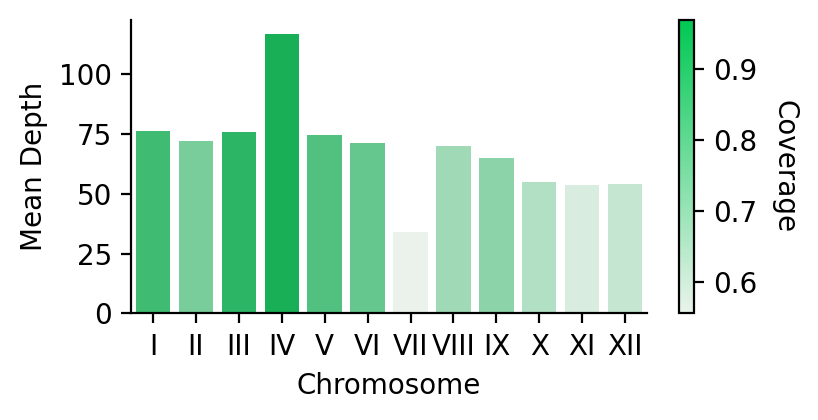

In [19]:
coverage = pd.read_csv("alignment/reads/illumina-coverage.tsv", sep="\t")
coverage["chr"] = [
    "I", "II", "III", "IV", "V", "VI", "VII", "VIII", "IX", "X", "XI", "XII"
]
x = coverage["chr"]
y = coverage["meandepth"]
c = coverage["coverage"] / 100
color = "#00c853"
cmap = sns.light_palette(color, as_cmap=True, n_colors=12)
palette = sns.light_palette(color, n_colors=12)
fig, ax = plt.subplots(figsize=(4.2, 2.2), dpi=200)
norm = plt.Normalize(c.min(), c.max())
sm = ScalarMappable(cmap=cmap, norm=norm)
sns.barplot(x=x, y=y, hue=c, dodge=False, ax=ax, palette=palette)
ax.get_legend().remove()
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Coverage", rotation=270, labelpad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Chromosome")
ax.set_ylabel("Mean Depth")
plt.tight_layout()
plt.savefig("img/illumina-coverage.svg", transparent=True)

##### Read coverage diagram

In [35]:
data = pd.read_csv(
    "alignment/illumina-depth.tsv", sep="\t", header=None,
    names=["chr", "pos", "depth"])
data

,chr,pos,depth
0,NC_072840.1,1,1
1,NC_072840.1,2,1
2,NC_072840.1,3,2
3,NC_072840.1,4,2
4,NC_072840.1,5,2
...,...,...,...
50358844,NC_072851.1,2552981,0
50358845,NC_072851.1,2552982,0
50358846,NC_072851.1,2552983,0
50358847,NC_072851.1,2552984,0


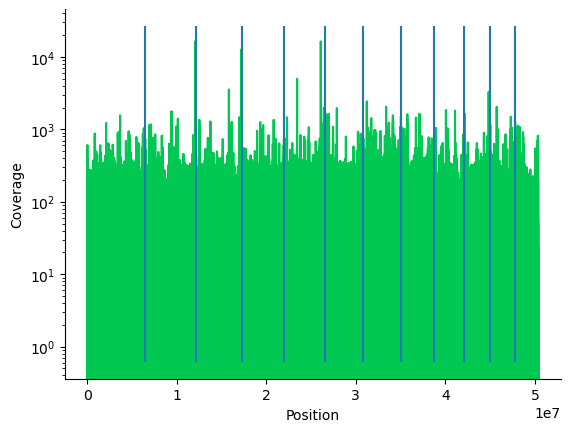

In [2]:
data = pd.read_csv(
    "alignment/illumina-depth.tsv", sep="\t", header=None,
    names=["chr", "pos", "depth"])
fig, ax = plt.subplots()
ax.plot(data.index, data.depth, color="#00c853")
ax.set_yscale("log")
ax.fill_between(data.index, data.depth, color="#00c853")
ax.set_xlabel("Position")
ax.set_ylabel("Coverage")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.vlines(data[data.pos == 1].index[1:], ax.get_ylim()[0], ax.get_ylim()[1])

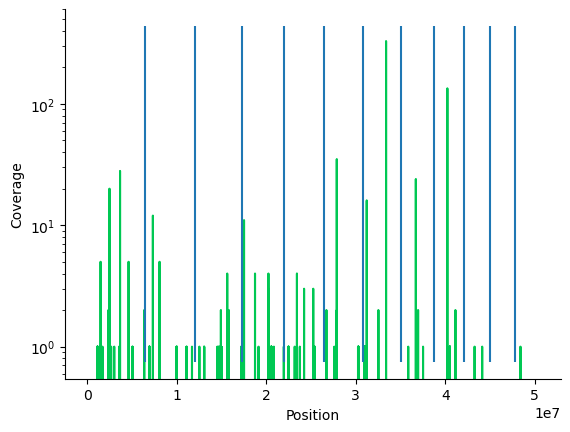

In [3]:
data = pd.read_csv(
    "alignment/nanopore-depth.tsv", sep="\t", header=None,
    names=["chr", "pos", "depth"])
fig, ax = plt.subplots()
ax.plot(data.index, data.depth, color="#00c853")
ax.set_yscale("log")
ax.fill_between(data.index, data.depth, color="#00c853")
ax.set_xlabel("Position")
ax.set_ylabel("Coverage")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.vlines(data[data.pos == 1].index[1:], ax.get_ylim()[0], ax.get_ylim()[1])

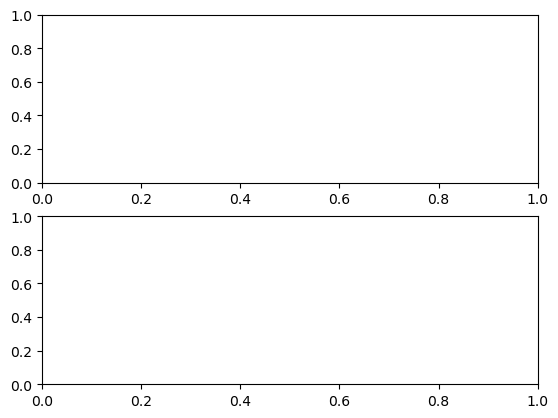

In [6]:
fig, ax = plt.subplots(2, 1)


##### Read length histogram

/tmp/ipykernel_62071/3764247087.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f"{int(x)}K" for x in plt.gca().get_xticks()/1000])
/tmp/ipykernel_62071/3764247087.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f"{int(y)}" for y in plt.gca().get_yticks()])


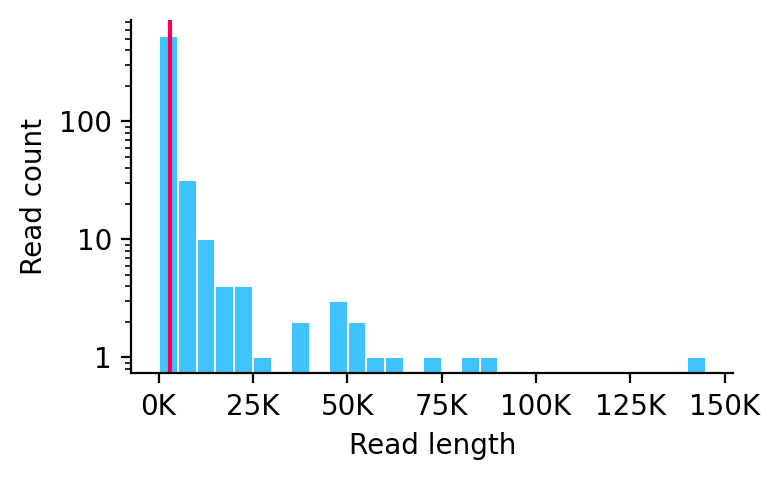

In [21]:
# Get read length from all reads
with gzip.open("fus11/reads/trimmed/nanopore.fq.gz", "rt") as handle:
    lengths = [len(record.seq) for record in SeqIO.parse(handle, "fastq")]

# Create figure
plt.figure(figsize=(4, 2.5), dpi=200)
sns.histplot(lengths, binwidth=5000, color="#00b0ff", edgecolor="white")
plt.xlabel("Read length")
plt.ylabel("Read count")

# Use logarithmic scale for y axis as read lengths vary significantly
plt.yscale("log")

# Remove top and right lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Simplify tick labels
plt.gca().set_xticklabels([f"{int(x)}K" for x in plt.gca().get_xticks()/1000])
plt.gca().set_yticklabels([f"{int(y)}" for y in plt.gca().get_yticks()])
plt.tight_layout()
plt.axvline(np.mean(lengths), color="#f50057")
plt.savefig("img/read-length.svg", transparent=True)

In [83]:
np.mean(lengths)

3148.264755480607